In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

### Problem 1

In [2]:
def make_Ak(k, d=10):
    A = np.zeros((d, d))
    for i in range(1, d+1):
        for j in range(1, d+1):
            if i < j:
                A[i-1, j-1] = np.exp(i/j) * np.cos(i*j) * np.sin(k)
    A += A.T
    for i in range(1, d+1):
        A[i-1, i-1] = i/d * np.abs(np.sin(k)) + np.sum(np.abs(A[i-1, :])) 
    return A

def make_bk(k, d=10):
    b = np.zeros(d)
    for i in range(1, d+1):
        b[i-1] = np.exp(i/k) * np.sin(i*k)
    return b

In [3]:
Ak_list = [make_Ak(k) for k in range(1, 6)]
bk_list = [make_bk(k) for k in range(1, 6)]

In [10]:
get_fk = lambda x: [x.T @ Ak_list[i] @ x - bk_list[i].T @ x for i in range(5)]
maxquad = lambda x: max(get_fk(x))

In [9]:
x_init = np.ones(10)
maxquad(x_init)

5337.066429311364

In [11]:
# the subgradient of the maxquad function at x
def maxquad_subgrad(x):
    fk = get_fk(x)
    k_active = np.argmax(fk) # k s.t. fk = f (0 indexed)
    # g is a subgradient of f at x if it is a subgradient of fk at x where fk(x) = f(x)
    g = 2 * Ak_list[k_active] @ x - bk_list[k_active]
    return g

In [35]:
x = cp.Variable(10)
loss = cp.max(cp.hstack([cp.quad_form(x, Ak_list[k]) - bk_list[k] @ x for k in range(5)]))
prob = cp.Problem(cp.Minimize(loss))
f_opt = prob.solve()
print(f_opt)

-0.8414083342082411


In [38]:
# compute f_i_minus
def get_f_minus(x_list):
    x = cp.Variable(10)
    fi = cp.max(cp.hstack([maxquad(xj) + maxquad_subgrad(xj) @ (x-xj) for xj in x_list]))
    prob = cp.Problem(cp.Minimize(fi), [cp.norm(x) <= 1])
    f_opt = prob.solve()
    return f_opt

In [39]:
def project_on_Q(x_list, level):
    x = cp.Variable(10)
    fi = cp.max(cp.hstack([maxquad(xj) + maxquad_subgrad(xj) @ (x-xj) for xj in x_list]))
    constraints = [cp.norm(x) <= 1, fi <= level] # G is chosen to be the unit ball 
    prob = cp.Problem(cp.Minimize(cp.norm(x - x_list[-1])), constraints)
    prob.solve()
    return x.value

In [40]:
get_f_minus([x_init])

-12889.51247511077

In [64]:
def level_method(lamb=0.5, max_iter=100000, epsilon=1e-6):
    x_init = np.ones(10)
    f_plus_list = [] # stores min_j<=i{f(xj)}
    f_plus_list.append(maxquad(x_init))
    x_list = []
    x_list.append(x_init)
    # at iterate i, compute x_i+1
    for i in range(max_iter):
        # the pointwise max of affine forms
        f_minus = get_f_minus(x_list)
        level = (1-lamb) * f_minus + lamb * f_plus_list[i]
        x = project_on_Q(x_list, level)
        x_list.append(x)
        f_plus_list.append(min(maxquad(x), f_plus_list[-1]))
        if i % 1 == 0:
            print('i: {}, fi_plus: {}'.format(i, f_plus_list[-1]))
        if abs(f_plus_list[-1] - f_minus) < epsilon:
            print('converges at iterate {}'.format(i))
            break
    return f_plus_list

In [65]:
f_plus_list = level_method(lamb=0.5)

i: 0, fi_plus: 47.60379098532603
i: 1, fi_plus: 31.25796027197014
i: 2, fi_plus: 8.592124437771627
i: 3, fi_plus: 2.9165143382593963
i: 4, fi_plus: 2.9165143382593963
i: 5, fi_plus: 2.9165143382593963
i: 6, fi_plus: 1.0339636416595699
i: 7, fi_plus: 1.0339636416595699
i: 8, fi_plus: -0.614546639565047
i: 9, fi_plus: -0.614546639565047
i: 10, fi_plus: -0.614546639565047
i: 11, fi_plus: -0.703815564316979
i: 12, fi_plus: -0.703815564316979
i: 13, fi_plus: -0.703815564316979
i: 14, fi_plus: -0.7302990996486447
i: 15, fi_plus: -0.7409958130759984
i: 16, fi_plus: -0.8074717985130044
i: 17, fi_plus: -0.8237860730819486
i: 18, fi_plus: -0.8237860730819486
i: 19, fi_plus: -0.8237860730819486
i: 20, fi_plus: -0.8237860730819486
i: 21, fi_plus: -0.8237860730819486
i: 22, fi_plus: -0.8282771826262033
i: 23, fi_plus: -0.8313952428917439
i: 24, fi_plus: -0.8313952428917439
i: 25, fi_plus: -0.8367394804006906
i: 26, fi_plus: -0.8390754665460889
i: 27, fi_plus: -0.8390754665460889
i: 28, fi_plus: -0.

/opt/anaconda3/envs/env-structure/lib/python3.9/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


i: 72, fi_plus: -0.8414079853712059
i: 73, fi_plus: -0.8414079853712059
i: 74, fi_plus: -0.8414079853712059
converges at iterate 74


Text(0, 0.5, 'suboptimality gap (log)')

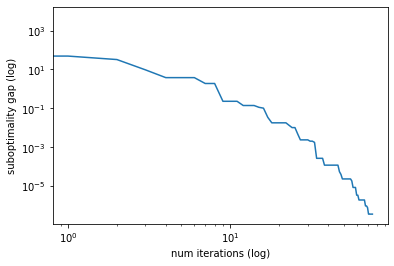

In [66]:
plt.loglog(np.arange(len(f_plus_list)), np.array(f_plus_list) - f_opt)
plt.xlabel('num iterations (log)')
plt.ylabel('suboptimality gap (log)')

### Problem 2

In [175]:
def gradient_descent(f, grad, step_size, max_iter=100000, epsilon=1e-3, num_iter_log=1e3):
    f_best = np.full(max_iter, np.nan)
    f_best[0] = f(x_init)
    x_prev = x_init
    for i in range(1, max_iter):
        x = x_prev - step_size * grad(x_prev)
        x_prev = x
        if f(x) < f_best[i-1]:
            f_best[i] = f(x)
        else:
            f_best[i] = f_best[i-1]
        if np.allclose(grad(x), 0, atol=epsilon):
            print('converges at iteration {}'.format(i))
            break
        if i % num_iter_log == 0:
            print('iteration {}, f {}'.format(i, f(x)))
    return f_best

In [176]:
def agd(f, grad, step_size=1e-2, C=1/2, max_iter=100000, epsilon=1e-3, num_iter_log=1e2):
    f_best = np.full(max_iter, np.nan)
    gamma_list = [0 if t <= 3 else 2 / t for t in range(max_iter)]
    lamb = 1
    f_best[0] = f(x_init)
    x_prev = x_init
    z_prev = x_prev
    for i in range(1, max_iter):
        gamma = gamma_list[i]
        lamb *= 1 - gamma
        y_prev = (1-gamma) * x_prev + gamma * z_prev
        z = z_prev - gamma/(lamb*2*C) * grad(y_prev)
        x = y_prev - step_size * grad(y_prev)
        if f(x) < f_best[i-1]:
            f_best[i] = f(x)
        else:
            f_best[i] = f_best[i-1]
        if np.allclose(grad(x), 0, atol=epsilon):
            print('converges at iteration {}'.format(i))
            break
        if i % num_iter_log == 0:
            print('iteration {}, f {}'.format(i, f(x)))
        x_prev = x
        z_prev = z
    return f_best

#### Part (a)

In [168]:
np.random.seed(1)
x_init = np.ones(20)
A = np.random.normal(size=(20, 20))
f = lambda x: np.linalg.norm(A @ x)**2
grad = lambda x: 2 * A.T @ A @ x

In [169]:
f(x_init)

217.4978923321783

In [170]:
f_best_gd = gradient_descent(f, grad, 1e-2)
f_best_gd = f_best_gd[~np.isnan(f_best_gd)]

iteration 1000, f 0.006788650333388579
iteration 2000, f 0.005882282740535028
iteration 3000, f 0.005117465114918679
iteration 4000, f 0.004452621889609332
iteration 5000, f 0.003874166523436946
iteration 6000, f 0.003370860630741733
iteration 7000, f 0.0029329408941594698
iteration 8000, f 0.002551912769985145
iteration 9000, f 0.0022203852790212753
iteration 10000, f 0.0019319276290636984
iteration 11000, f 0.0016809444735577136
iteration 12000, f 0.001462567376063462
iteration 13000, f 0.0012725603749407406
iteration 14000, f 0.001107237816440289
iteration 15000, f 0.0009633928623720962
iteration 16000, f 0.0008382352855806297
iteration 17000, f 0.0007293373466172236
iteration 18000, f 0.0006345867017542629
iteration 19000, f 0.0005521454288761386
iteration 20000, f 0.0004804143764532771
iteration 21000, f 0.0004180021440597023
iteration 22000, f 0.00036369809273495435
converges at iteration 22363


In [171]:
f_best_agd = agd(f, grad, 1e-2, 1e2)

iteration 100, f 0.008730311372226695
iteration 200, f 0.006191283110895155
iteration 300, f 0.004466819923472647
iteration 400, f 0.002791803026720182
iteration 500, f 0.0014261763620947768
iteration 600, f 0.0005320941452097991
converges at iteration 636


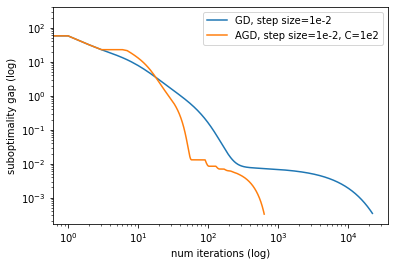

In [172]:
plt.loglog(np.arange(f_best_gd.size), f_best_gd, label='GD, step size=1e-2')
plt.loglog(np.arange(f_best_agd.size), f_best_agd, label='AGD, step size=1e-2, C=1e2')
plt.xlabel('num iterations (log)')
plt.ylabel('suboptimality gap (log)')
plt.legend()

#### Part (b)

In [173]:
dim = 20
A = np.zeros((dim, dim))
A[np.diag_indices_from(A)] = 2
for i in range(dim):
    if i < dim-1:
        A[i, i+1] = -1
    if i > 0:
        A[i, i-1] = -1
x_init = np.ones(20)
f = lambda x: x.T @ A @ x
grad = lambda x: 2 * A @ x

In [182]:
f_best_gd = gradient_descent(f, grad, 1e-1, num_iter_log=1e2)
f_best_gd = f_best_gd[~np.isnan(f_best_gd)]

iteration 100, f 0.15481953162155973
iteration 200, f 0.06318095693102285
iteration 300, f 0.025802374489200412
iteration 400, f 0.010537398043347778
iteration 500, f 0.004303354236491689
iteration 600, f 0.0017574412211207701
iteration 700, f 0.0007177191269785969
iteration 800, f 0.0002931083777029042
iteration 900, f 0.00011970214788798605
converges at iteration 902


In [190]:
f_best_agd = agd(f, grad, 1e-1, 1e1, num_iter_log=1e1)

iteration 10, f 0.6821172779588512
iteration 20, f 0.37611311845821016
iteration 30, f 0.2577490762205275
iteration 40, f 0.18807830933598543
iteration 50, f 0.12692532231702247
iteration 60, f 0.07483075172793287
iteration 70, f 0.03768145070032799
iteration 80, f 0.014739127879091072
iteration 90, f 0.0034057414622151853
iteration 100, f 7.471380628819837e-05
converges at iteration 102


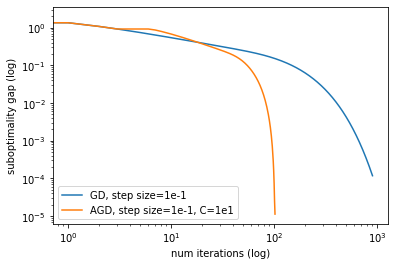

In [192]:
plt.loglog(np.arange(f_best_gd.size), f_best_gd, label='GD, step size=1e-1')
plt.loglog(np.arange(f_best_agd.size), f_best_agd, label='AGD, step size=1e-1, C=1e1')
plt.xlabel('num iterations (log)')
plt.ylabel('suboptimality gap (log)')
plt.legend()